In [28]:
!pip install graphviz

# Importación de los datos

En primer lugar se importarán los ficheros relativos al conjunto de datos de **entrenamiento** y **test**. Para ello se han descargado de la competición de Kaggle y se han subido a un repositorio público en **GitHub** desde donde se importarán. Haciendo esto evitamos tener que adjuntar al notebook los ficheros cada vez que vayamos a trabajar, ya que estos se **importarán automáticamente** desde el repositorio.

In [29]:
import pandas as pd
import requests
import io

train_url = "https://raw.githubusercontent.com/cturienzo/LinearRegressionDataset/main/train.csv"
test_url = "https://raw.githubusercontent.com/cturienzo/LinearRegressionDataset/main/test.csv"

train_request = requests.get(train_url).content
test_request = requests.get(test_url).content

train = pd.read_csv(io.StringIO(train_request.decode('utf-8')))
test = pd.read_csv(io.StringIO(test_request.decode('utf-8')))


Una vez importados los datos, vamos a separarlos en diferentes variables para facilitar la comprensión:

**X_train** se corresponderá con la matriz que contiene los valores de las características del conjunto de datos de entrenamiento.

**y_train** se corresponderá con la matriz unidimensional de valores de la variable objetivo.

**X_test** se corresponderá con la matriz que contiene los valores de las características del conjunto de datos de test.

In [30]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test

# Pre-procesamiento

### Variables Continuas

Para estudiar las variables continuas observamos su relación con la variable objetivo así como su distribución. De esta forma podremos aplicar un transformador u otro.

**Nota**: la variable edad a pesar de ser discreta, toma mucho valores diferentes y se tratará como una variable aleatoria continua.

In [31]:
import matplotlib.pyplot as plt

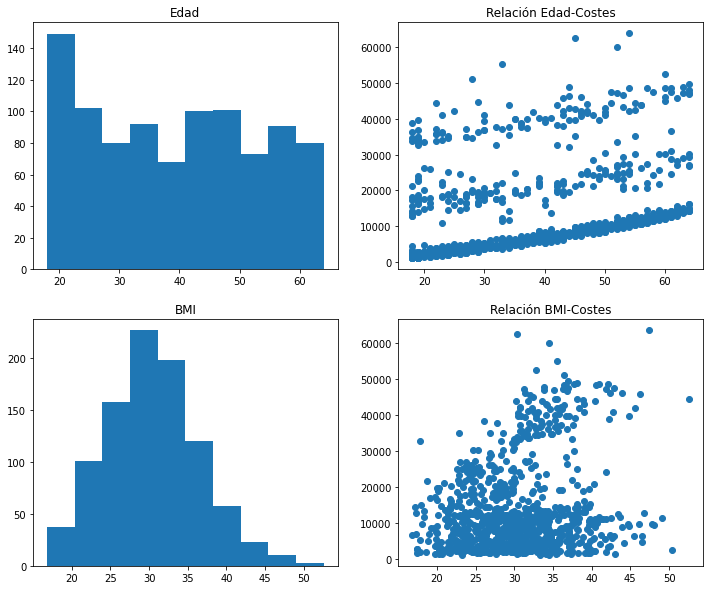

In [32]:
from sklearn.preprocessing import StandardScaler


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

axs[0, 0].set_title('Edad')
axs[0, 0].hist(train["age"])

axs[0, 1].set_title('Relación Edad-Costes')
axs[0, 1].scatter(train["age"], y_train)

axs[1, 0].set_title('BMI')
axs[1, 0].hist(train["bmi"])

axs[1, 1].set_title('Relación BMI-Costes')
axs[1, 1].scatter(train["bmi"], y_train)






### Variables Discretas

Para estudiar las variables discretas vamos a conocer la relación de cada una con su variable objetivo.

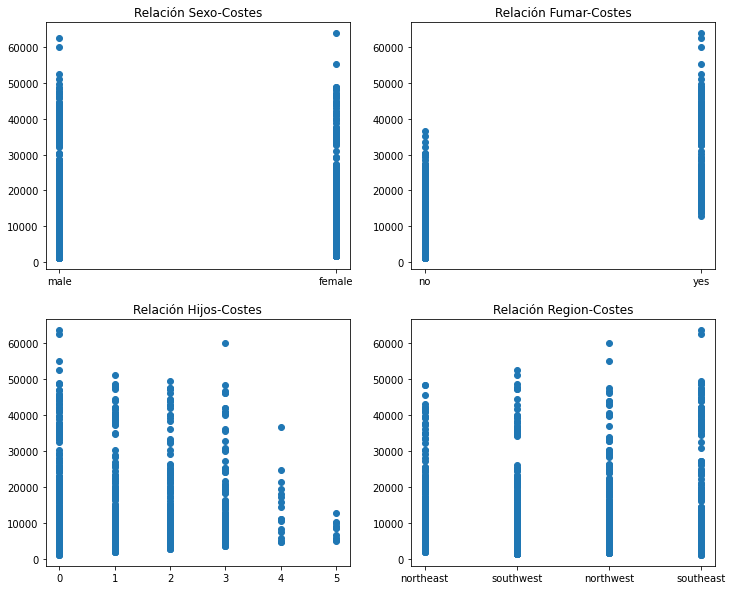

In [33]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

axs[0, 0].set_title('Relación Sexo-Costes')
axs[0, 0].scatter(train["sex"], y_train)

axs[0, 1].set_title('Relación Fumar-Costes')
axs[0, 1].scatter(train["smoker"], y_train)

axs[1, 0].set_title('Relación Hijos-Costes')
axs[1, 0].scatter(train["children"], y_train)

axs[1, 1].set_title('Relación Region-Costes')
axs[1, 1].scatter(train["region"], y_train)

Tras el análisis y el estudio de las diferentes features, aplicaremos a cada una los siguientes **transformadores**:
1. **Id**: *Drop*. Lo vamos eliminar del conjunto de datos pues no influye en la variable objetivo.
2. **Age**: *Passthrough*. 
3. **Sex**: *OneHotEncoder* 
4. **BMI**: *Passthrough*.
5. **Children**: *OneHotEnconder*
6. **Smoker**: *OneHotEncoder* 
7. **Region**: usaremos *OrdinalEnconder*.

In [34]:
import sklearn.compose
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("id drop", "drop", [0]),
    ("age","passthrough", [1]), 
    ("sex", sklearn.preprocessing.OneHotEncoder(), [2]),
    ("bmi", "passthrough", [3]),
    ("children",sklearn.preprocessing.OneHotEncoder(), [4]),  
    ("smoker", sklearn.preprocessing.OneHotEncoder(), [5]),
    ("region", sklearn.preprocessing.OrdinalEncoder(), [6]),
   
])

X_train_transform = column_transformer.fit_transform(X_train)
X_test_transform = column_transformer.fit_transform(X_test)
X_train_transform

array([[58.,  0.,  1., ...,  1.,  0.,  0.],
       [54.,  1.,  0., ...,  1.,  0.,  0.],
       [64.,  1.,  0., ...,  1.,  0.,  3.],
       ...,
       [55.,  1.,  0., ...,  1.,  0.,  0.],
       [20.,  1.,  0., ...,  1.,  0.,  3.],
       [57.,  0.,  1., ...,  0.,  1.,  2.]])

# Entrenamiento del modelo

Para el entrenamiento del modelo, hemos decidido utilizar [***XGBRegressor***](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) (*Extreme Gradient Boosting*)

[09:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


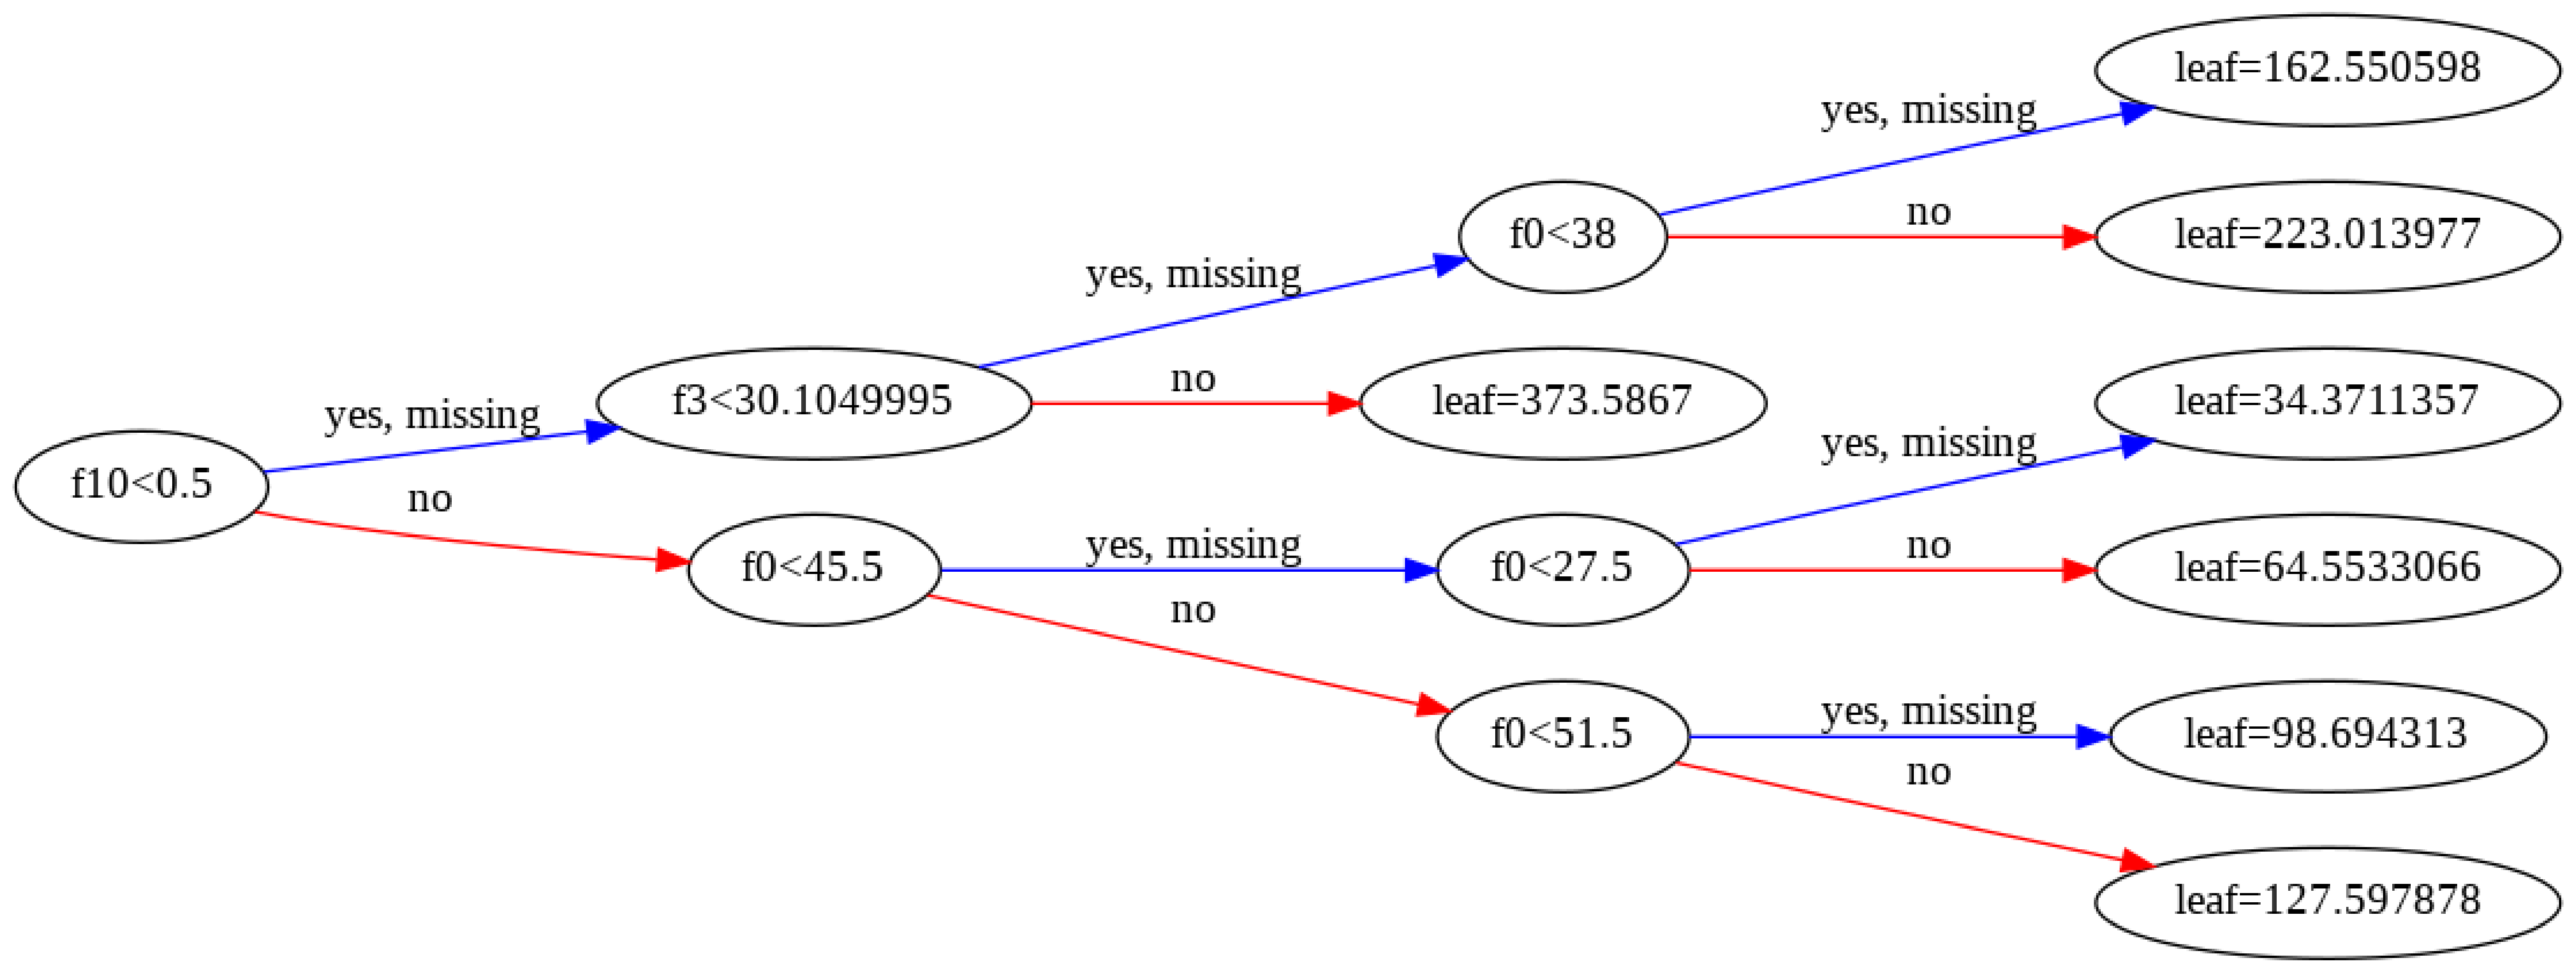

In [40]:
from xgboost.sklearn import XGBRegressor
from xgboost import plot_tree
from matplotlib.pylab import rcParams

xgbr = XGBRegressor(subsample=0.8,                                          
                    n_estimators=500,                                           
                    max_depth=3,                                          
                    learning_rate= 0.01,                                          
                    colsample_bytree = 1,                                          
                    colsample_bylevel= 1,                     
                    random_state= 43                             
                    ).fit(X_train_transform, y_train)
y_pred = xgbr.predict(X_test_transform)
y_pred

rcParams['figure.figsize'] = 100,100
plot_tree(xgbr, num_trees= 10,  rankdir='LR')








XGBRegressor() es un algoritmo de la familia **ensemble** y se construye a partir de modelos de áboles de decisión. Se van añadiendo árboles de uno en uno cada árbol va ajustando más la solución corrigiendo los errores de predicción realizados por los anteriores modelos. 

Estos modelos se entrenan utilizando una función de pérdida arbitraria y utilizando el algoritmo de **optimización de descenso de gradiente**. Según se minimiza la función de pérdida se va ajustando más a la solución.

Entre sus *parámetros* encontramos:

**learning_rate** este parámetro es la velocidad de aprendizaje del modelo. Valores muy elevados aprenderá demasiado rápido y no se ajustrá correctamente. Sin embargo valores muy pequeños tendrán el riesgo de ajustarse mucho y caer en mínimos locales. Hay que buscar el valor adecuado para el aprendizaje del modelo.

**num_estimators** este parámetro son el número de árboles que se crean para el aprendizaje del modelo. Un número muy elevado de árboles producirá *overfitting* pues se ajustará demasiado a los datos de entrenamiento y no será capaz de generalizar con nuevos datos.

**max_depth** este parámetro trata la profundidad de los árboles.

**subsample** este parámetro nos indica el número de filas de nuestro conjunto de datos que se usarán en cada árbol.

**random_state** este parámetro define la semilla de aleatoriedad que utiliza el modelo para su entrenamiento. De esta forma siempre utilizará la misma semilla y no producirá resultados distintos en cada entrenamiento.

**colsample_bytree** este parámetro nos indica el número de features (columnas) del conjunto de datos usadas en cada árbol. Indicando 1 usaremos todas las columnas.

**colsample_bylevel** este parámetro nos indica el número de features (columnas) del conjunto de datos usadas en cada profundidad del árbol. Indicando 1 usaremos todas las columnas.


Para evitar el *overfitting* en nuestro modelo hemos utilizado el parametro **subsample** que ayuda a que el modelo sea más conservativo, por lo tanto, que se reduzca el *overfitting*. También para evitar el *overfitting* hemos ajustado los parametros **max_depth** y **learning_rate**, valores altos de estos parametro provocan que el modelo sea mas complejo y mas apto para el *overfitting*. Por otro lado, el **num_estimators** también influye en el *overfitting*, si aumentamos el num_árboles

(https://machinelearningmastery.com/xgboost-for-regression/)
(https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/)

# Validación del modelo

Para la validación del modelo se realizará **validación cruzada** realizando  **10**  separaciones diferentes y aleatorias del conjunto de datos para calcular las medidas de calidad de cada una de estas separaciones. Este proceso lo repite 3 veces  y luego agrupa los resultados con la **media**.

In [36]:


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import numpy as np

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgbr, X_train_transform, y_train, scoring='r2', cv=cv)

np.mean(scores), xgbr.score(X_train_transform, y_train)

[09:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

(0.850563201202758, 0.8844295606199775)

### Generación csv predicciones

Una vez entrenado y validado el modelo, se **generará el csv** con las predicciones y se subirá a la competición.

In [37]:
predicciones = pd.DataFrame({'id':X_test["id"], 'charges': y_pred })
predicciones.to_csv("prediccionesXGB.csv", index=False)

<hr>

Creado por **Pablo Gutiérrez Rojas** (p.grojas@alumnos.upm.es) y **César Turienzo Forcada** (c.turienzo@alumnos.upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">